In [ ]:
import cv2, os, csv, json, math
import numpy as np


def resize_to_fit(frame, max_w=480, max_h=600):
    h, w = frame.shape[:2]
    scale = min(max_w / w, max_h / h, 1.0)
    return cv2.resize(frame, (int(w*scale), int(h*scale))), scale

def scale_point(pt, scale):
    return (int(pt[0] / scale), int(pt[1] / scale))

def select_point(frame, title="Select Pivot"):
    sel = {'pt': None}
    def cb(ev, x, y, flags, param):
        if ev == cv2.EVENT_LBUTTONDOWN:
            sel['pt'] = (x, y)
    cv2.namedWindow(title); cv2.setMouseCallback(title, cb)
    while True:
        disp = frame.copy()
        if sel['pt']:
            cv2.circle(disp, sel['pt'], 5, (0,255,0), -1)
        cv2.imshow(title, disp)
        k = cv2.waitKey(10) & 0xFF
        if k==13 and sel['pt']: break    # Enter
        if k==27: 
            cv2.destroyWindow(title)
            return None
    cv2.destroyWindow(title)
    return sel['pt']

def manual_circle(frame, title="Select Bob ROI"):
    st = {'c':None, 'r':0, 'drag':False}
    def cb(ev, x, y, flags, param):
        if ev == cv2.EVENT_LBUTTONDOWN:
            st['c'], st['drag'] = (x,y), True
        elif ev == cv2.EVENT_MOUSEMOVE and st['drag']:
            st['r'] = int(math.hypot(x-st['c'][0], y-st['c'][1]))
        elif ev == cv2.EVENT_LBUTTONUP:
            st['drag'] = False
    cv2.namedWindow(title); cv2.setMouseCallback(title, cb)
    while True:
        disp = frame.copy()
        if st['c'] and st['r']>0:
            cv2.circle(disp, st['c'], st['r'], (0,255,0), 2)
        cv2.imshow(title, disp)
        k = cv2.waitKey(10) & 0xFF
        if k==13 and st['c'] and st['r']>0: break
        if k==27:
            cv2.destroyWindow(title)
            return None, None
    cv2.destroyWindow(title)
    return st['c'], st['r']


def track_two_pendula_csrt_with_fallback(
    video_path, output_dir,
    preview_w=480, preview_h=600
):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Cannot open {video_path}")
    ret, first = cap.read()
    if not ret:
        raise IOError("Cannot read first frame.")

    # 1) Preview & Selection
    preview, scale = resize_to_fit(first, preview_w, preview_h)
    # 1a) pivots
    p1 = select_point(preview, "Select Pivot 1")
    p2 = select_point(preview, "Select Pivot 2")
    if not p1 or not p2:
        print("Pivot selection cancelled."); return
    # 1b) initial bob circles
    c1p, r1p = manual_circle(preview, "Select Bob‑1 ROI")
    c2p, r2p = manual_circle(preview, "Select Bob‑2 ROI")
    if not c1p or not c2p:
        print("Bob ROI cancelled."); return

    pivot1 = scale_point(p1, scale)
    pivot2 = scale_point(p2, scale)
    c1_full = scale_point(c1p, scale)
    c2_full = scale_point(c2p, scale)
    r1 = int(r1p / scale)
    r2 = int(r2p / scale)

    # 3) Prepare output
    os.makedirs(output_dir, exist_ok=True)
    csv_path  = os.path.join(output_dir, "coordinates.csv")
    json_path = os.path.join(output_dir, "metadata.json")
    with open(csv_path, 'w', newline='') as f:
        csv.writer(f).writerow(['frame','bob1_x','bob1_y','bob2_x','bob2_y'])
    json.dump({
        'pivot1': pivot1, 'pivot2': pivot2,
        'init_center1': c1_full, 'init_center2': c2_full,
        'radius1_px': r1, 'radius2_px': r2
    }, open(json_path,'w'), indent=2)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    x1f = max(c1_full[0]-r1, 0)
    y1f = max(c1_full[1]-r1, 0)
    w1f = h1f = 2*r1
    tpl1 = cv2.cvtColor(first[y1f:y1f+h1f, x1f:x1f+w1f],
                        cv2.COLOR_BGR2GRAY)
    tpl1 = clahe.apply(tpl1)
    x2f = max(c2_full[0]-r2, 0)
    y2f = max(c2_full[1]-r2, 0)
    w2f = h2f = 2*r2
    tpl2 = cv2.cvtColor(first[y2f:y2f+h2f, x2f:x2f+w2f],
                        cv2.COLOR_BGR2GRAY)
    tpl2 = clahe.apply(tpl2)

    tracker1 = cv2.TrackerCSRT_create()
    tracker2 = cv2.TrackerCSRT_create()
    tracker1.init(first, (x1f, y1f, w1f, h1f))
    tracker2.init(first, (x2f, y2f, w2f, h2f))

    frame_idx = 0
    last_bb1, last_bb2 = (x1f,y1f,w1f,h1f), (x2f,y2f,w2f,h2f)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray_eq = clahe.apply(gray)

        ok1, bb1 = tracker1.update(frame)
        if ok1:
            x,y,w,h = map(int, bb1)
            if 0 <= x < frame.shape[1]-w and 0 <= y < frame.shape[0]-h:
                patch = gray_eq[y:y+h, x:x+w]
                if patch.shape == tpl1.shape:
                    res = cv2.matchTemplate(patch, tpl1, cv2.TM_CCOEFF_NORMED)
                    _,mx,_,_ = cv2.minMaxLoc(res)
                    if mx < 0.5:
                        ok1 = False
        if not ok1:
            res = cv2.matchTemplate(gray_eq, tpl1, cv2.TM_CCOEFF_NORMED)
            _ ,mx,_,tl = cv2.minMaxLoc(res)
            if mx > 0.4:
                bb1 = (tl[0], tl[1], w1f, h1f)
                tracker1 = cv2.TrackerCSRT_create()
                tracker1.init(frame, bb1)
                ok1 = True
        if not ok1:
            bb1 = last_bb1

       
        ok2, bb2 = tracker2.update(frame)
        if ok2:
            x,y,w,h = map(int, bb2)
            if 0 <= x < frame.shape[1]-w and 0 <= y < frame.shape[0]-h:
                patch = gray_eq[y:y+h, x:x+w]
                if patch.shape == tpl2.shape:
                    res = cv2.matchTemplate(patch, tpl2, cv2.TM_CCOEFF_NORMED)
                    _,mx2,_,_ = cv2.minMaxLoc(res)
                    if mx2 < 0.5:
                        ok2 = False
        if not ok2:
            res = cv2.matchTemplate(gray_eq, tpl2, cv2.TM_CCOEFF_NORMED)
            _ ,mx2,_,tl2 = cv2.minMaxLoc(res)
            if mx2 > 0.4:
                bb2 = (tl2[0], tl2[1], w2f, h2f)
                tracker2 = cv2.TrackerCSRT_create()
                tracker2.init(frame, bb2)
                ok2 = True
        if not ok2:
            bb2 = last_bb2

        last_bb1, last_bb2 = bb1, bb2

    
        x1,y1,w1,h1 = map(int, bb1)
        x2,y2,w2,h2 = map(int, bb2)
        c1 = (x1 + w1//2, y1 + h1//2)
        c2 = (x2 + w2//2, y2 + h2//2)

        with open(csv_path, 'a', newline='') as f:
            csv.writer(f).writerow([frame_idx, c1[0], c1[1], c2[0], c2[1]])

       
        preview_frame, sc2 = resize_to_fit(frame, preview_w, preview_h)
        def draw_bb(bb, color):
            x,y,w,h = bb
            x_,y_ = int(x*sc2), int(y*sc2)
            cv2.rectangle(preview_frame, (x_,y_),
                          (x_+int(w*sc2), y_+int(h*sc2)), color, 2)
        
        cv2.circle(preview_frame,
                   (int(pivot1[0]*sc2), int(pivot1[1]*sc2)), 5, (0,0,255), -1)
        cv2.circle(preview_frame,
                   (int(pivot2[0]*sc2), int(pivot2[1]*sc2)), 5, (0,0,255), -1)
        draw_bb(bb1, (255,0,0))
        draw_bb(bb2, (0,255,0))
        cv2.putText(preview_frame, f"Frame {frame_idx}",
                    (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.7,
                    (255,255,255), 2)

        cv2.imshow("CSRT + Template Fallback", preview_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_idx += 1

    cap.release()
    cv2.destroyAllWindows()
    print("Tracking complete.")
    print(" • CSV →", csv_path)
    print(" • Metadata →", json_path)



track_two_pendula_csrt_with_fallback(
    video_path=r"C:\Users\avsha\Documents\cupled_pendulum_tracking\WhatsApp Video 2025-03-26 at 10.53.40_a8cc1bf2.mp4",
    output_dir=R"C:\Users\avsha\Documents\GitHub\Ants\temp")

    
    
    

Tracking complete.
 • CSV → C:\Users\avsha\Documents\GitHub\Ants\temp\coordinates.csv
 • Metadata → C:\Users\avsha\Documents\GitHub\Ants\temp\metadata.json


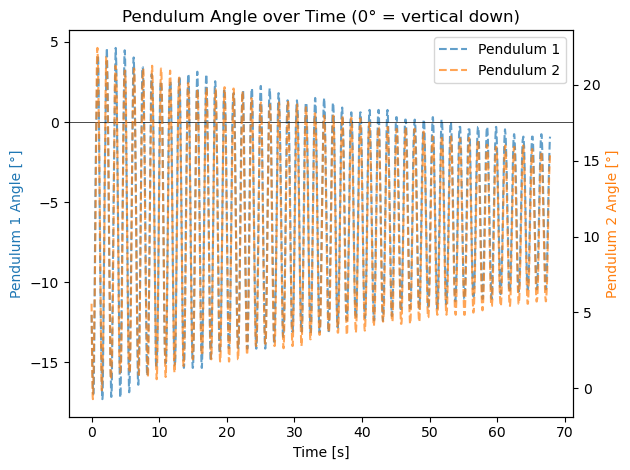

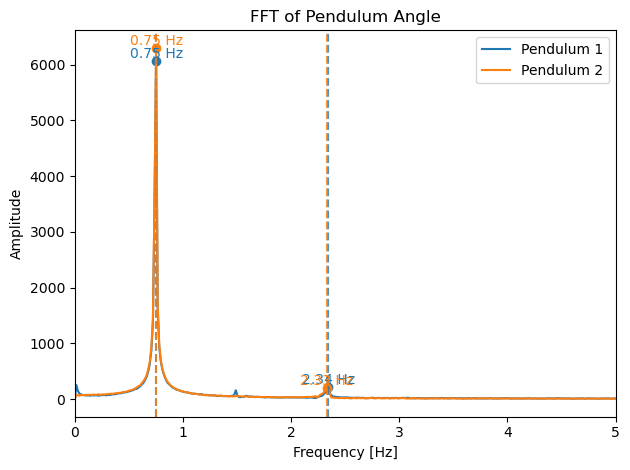

In [ ]:
import cv2
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq

video_path = r"C:\Users\avsha\Documents\cupled_pendulum_tracking\WhatsApp Video 2025-03-26 at 10.53.40_a8cc1bf2.mp4"
csv_path   = R"C:\Users\avsha\Documents\GitHub\Ants\temp\coordinates.csv"
json_path  = R"C:\Users\avsha\Documents\GitHub\Ants\temp\metadata.json"



df   = pd.read_csv(csv_path)
meta = json.load(open(json_path))
px1, py1 = meta['pivot1']
px2, py2 = meta['pivot2']

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()
t = df['frame'].values / fps

x1, y1 = df['bob1_x'].values, df['bob1_y'].values
x2, y2 = df['bob2_x'].values, df['bob2_y'].values

ang1 = np.degrees(np.arctan2(y1-py1, x1-px1)) - 90.0
ang2 = np.degrees(np.arctan2(y2-py2, x2-px2)) - 90.0

# FFT prep
N  = len(ang1)
xf = rfftfreq(N, 1/fps)
a1 = ang1 - np.mean(ang1)
a2 = ang2 - np.mean(ang2)
yf1 = np.abs(rfft(a1))
yf2 = np.abs(rfft(a2))

def peak_in_band(y, x, fmin, fmax):
    mask = (x>=fmin)&(x<=fmax)
    if not mask.any(): return None, None
    idx = np.argmax(y[mask])
    freqs = x[mask]; amps = y[mask]
    return freqs[idx], amps[idx]

p1_low,  A1_low  = peak_in_band(yf1, xf, 0, 1)
p1_high, A1_high = peak_in_band(yf1, xf, 2, 3)
p2_low,  A2_low  = peak_in_band(yf2, xf, 0, 1)
p2_high, A2_high = peak_in_band(yf2, xf, 2, 3)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

p1, = ax1.plot(t, ang1, '--', color='C0', alpha=0.7, label='Pendulum 1')
p2, = ax2.plot(t, ang2, '--', color='C1', alpha=0.7, label='Pendulum 2')

ax1.axhline(0, color='k', lw=0.5)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Pendulum 1 Angle [°]", color='C0')
ax2.set_ylabel("Pendulum 2 Angle [°]", color='C1')

# combined legend
lines = [p1, p2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title("Pendulum Angle over Time (0° = vertical down)")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(xf, yf1, color='C0', label='Pendulum 1')
plt.plot(xf, yf2, color='C1', label='Pendulum 2')

for f, A, c in [
    (p1_low,  A1_low,  'C0'),
    (p1_high, A1_high, 'C0'),
    (p2_low,  A2_low,  'C1'),
    (p2_high, A2_high, 'C1')
]:
    if f is None: continue
    plt.axvline(f, ls='--', color=c, alpha=0.8)
    plt.scatter([f], [A], color=c)
    plt.text(f, A, f"{f:.2f} Hz",
             ha='center', va='bottom', color=c)

plt.title("FFT of Pendulum Angle")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.xlim(0, 5)
plt.legend()
plt.tight_layout()
plt.show()

